In [7]:
import pandas as pd
import glob
import os
import re

ROOT = "./research_network"
loaded_tables = {}

# find folders that contain part.0.parquet
folders = sorted(set(os.path.dirname(p) for p in glob.glob(f"{ROOT}/**/part.0.parquet", recursive=True)))

for folder in folders:
    folder_name = os.path.basename(folder)
    table_name = re.sub(r"\.parquet$", "", folder_name)

    part_files = sorted(glob.glob(os.path.join(folder, "part.*.parquet")))
    if not part_files:
        print(f"⚠️ No part files found in {folder}")
        continue

    dfs = []
    for f in part_files:
        try:
            dfs.append(pd.read_parquet(f))
        except Exception as e:
            print(f"❌ Error reading {f}: {e}")

    df = pd.concat(dfs, ignore_index=True)

    # rename exact 'code' columns to {table_name}_code
    rename_map = {c: f"{table_name}_code" for c in df.columns if c.strip().lower() == "code"}
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
        print(f"✅ Renamed in '{table_name}': {rename_map}")

    df["source_name"] = table_name
    loaded_tables[table_name] = df
    globals()[table_name] = df  # optional

    print(f"✅ Loaded '{table_name}' ({len(part_files)} parts) → shape {df.shape}")

print("\nSummary of merged tables:")
for name, df in loaded_tables.items():
    print(f"  • {name:<20} {df.shape[0]} rows × {df.shape[1]} cols")


✅ Renamed in 'diagnosis': {'code': 'diagnosis_code'}
✅ Loaded 'diagnosis' (1605 parts) → shape (4296949, 11)
✅ Loaded 'encounter' (568 parts) → shape (1696490, 10)
✅ Renamed in 'lab_result': {'code': 'lab_result_code'}
✅ Loaded 'lab_result' (3711 parts) → shape (9991613, 11)
✅ Renamed in 'medication_drug': {'code': 'medication_drug_code'}
✅ Loaded 'medication_drug' (2250 parts) → shape (3790635, 14)
✅ Renamed in 'medication_ingredient': {'code': 'medication_ingredient_code'}
✅ Loaded 'medication_ingredient' (5419 parts) → shape (10427367, 12)
✅ Loaded 'patient' (5 parts) → shape (9999, 12)
✅ Renamed in 'procedure': {'code': 'procedure_code'}
✅ Loaded 'procedure' (961 parts) → shape (3098180, 9)
✅ Renamed in 'vitals_signs': {'code': 'vitals_signs_code'}
✅ Loaded 'vitals_signs' (1839 parts) → shape (4964930, 11)

Summary of merged tables:
  • diagnosis            4296949 rows × 11 cols
  • encounter            1696490 rows × 10 cols
  • lab_result           9991613 rows × 11 cols
  • med

In [8]:
vitals_signs.head()

,patient_id,encounter_id,code_system,vitals_signs_code,date,value,text_value,units_of_measure,derived_by_TriNetX,source_id,source_name
0,LhZq,OBEU,LOINC,3141-9,20171211,190,None,[lb_av],F,EHR,vitals_signs
1,LhZq,OBEU,LOINC,39156-5,20171211,26.5,None,kg/m2,F,EHR,vitals_signs
2,LhZq,OBEU,LOINC,8302-2,20171211,71,None,[in_us],F,EHR,vitals_signs
3,Nh7C,QxBG,LOINC,39156-5,20230530,25.67,None,kg/m2,F,EHR,vitals_signs
4,Nh7C,QhBG,LOINC,39156-5,20240501,25.02,None,kg/m2,F,EHR,vitals_signs


# Test 

In [6]:
for name, df in globals().items():
    if isinstance(df, pd.DataFrame):
        print(f"\n=== {name.upper()} ===")
        print(f"Shape: {df.shape}")
        print("Columns:", list(df.columns))



=== MERGED_DF ===
Shape: (4964930, 11)
Columns: ['patient_id', 'encounter_id', 'code_system', 'df_code', 'date', 'value', 'text_value', 'units_of_measure', 'derived_by_TriNetX', 'source_id', 'source_name']

=== DIAGNOSIS ===
Shape: (4296949, 11)
Columns: ['patient_id', 'encounter_id', 'code_system', 'diagnosis_code', 'principal_diagnosis_indicator', 'admitting_diagnosis', 'reason_for_visit', 'date', 'derived_by_TriNetX', 'source_id', 'source_name']

=== ENCOUNTER ===
Shape: (1696490, 10)
Columns: ['encounter_id', 'patient_id', 'start_date', 'end_date', 'type', 'start_date_derived_by_TriNetX', 'end_date_derived_by_TriNetX', 'derived_by_TriNetX', 'source_id', 'source_name']

=== LAB_RESULT ===
Shape: (9991613, 11)
Columns: ['patient_id', 'encounter_id', 'code_system', 'lab_result_code', 'date', 'lab_result_num_val', 'lab_result_text_val', 'units_of_measure', 'derived_by_TriNetX', 'source_id', 'source_name']

=== MEDICATION_DRUG ===
Shape: (3790635, 14)
Columns: ['patient_id', 'encounter

In [3]:
print("Unique patient IDs:", patient["patient_id"].nunique())
print("Unique encounter IDs:", encounter["encounter_id"].nunique())


Unique patient IDs: 9999
Unique encounter IDs: 1653271


In [4]:
encounter["patient_id"].isna().sum()  # should be 0



np.int64(0)

In [9]:
encounter["encounter_id"].duplicated().sum()

np.int64(543)

In [8]:
def missing_summary(df):
    summary = df.isna().sum()
    summary = summary[summary > 0].sort_values(ascending=False)
    return summary

for name, df in globals().items():
    if isinstance(df, pd.DataFrame):
        print(f"\n{name.upper()} missing summary:")
        display(missing_summary(df))



__ missing summary:


text_value    5
dtype: int64


DIAGNOSIS missing summary:


encounter_id    354
dtype: int64


LAB_RESULT missing summary:


lab_result_text_val    9644388
lab_result_num_val     1059898
units_of_measure         28560
dtype: int64


MEDICATION_DRUG missing summary:


quantity_dispensed    3725402
days_supply           3006063
dtype: int64


MEDICATION_INGREDIENT missing summary:


strength    367
dtype: int64


PATIENT missing summary:


month_year_death        7890
death_date_source_id    7890
year_of_birth           1132
sex                      300
dtype: int64


PROCEDURE missing summary:


Series([], dtype: int64)


VITALS_SIGNS missing summary:


text_value    4964930
value           99151
dtype: int64


_5 missing summary:


text_value    5
dtype: int64

In [9]:
# Create a copy of the globals dictionary to avoid modification during iteration
global_vars = globals().copy()

for name, df in global_vars.items():
    if isinstance(df, pd.DataFrame):
        unknown_counts = (df.astype(str)
                            .apply(lambda col: col.str.upper().eq("UNKNOWN").sum()))
        if unknown_counts.sum() > 0:
            print(f"\n{name.upper()} — 'UNKNOWN' value counts:")
            display(unknown_counts[unknown_counts > 0])


DIAGNOSIS — 'UNKNOWN' value counts:


principal_diagnosis_indicator    3377551
dtype: int64


ENCOUNTER — 'UNKNOWN' value counts:


type    693183
dtype: int64


LAB_RESULT — 'UNKNOWN' value counts:


lab_result_text_val    75554
dtype: int64


MEDICATION_DRUG — 'UNKNOWN' value counts:


brand        176531
strength    3580900
dtype: int64


MEDICATION_INGREDIENT — 'UNKNOWN' value counts:


route       3142223
brand       6131075
strength    5599601
dtype: int64


PATIENT — 'UNKNOWN' value counts:


race                         1241
ethnicity                    3095
marital_status               4754
patient_regional_location     483
dtype: int64


PROCEDURE — 'UNKNOWN' value counts:


principal_procedure_indicator    3098180
dtype: int64


SUB — 'UNKNOWN' value counts:


type    39
dtype: int64

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Exploring Encounter type

🎯 Randomly selected patient_id: rwnv


/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_4392/1733607930.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["start_date"] = pd.to_datetime(sub["start_date"], errors="coerce")
/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_4392/1733607930.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["end_date"] = pd.to_datetime(sub["end_date"], errors="coerce")


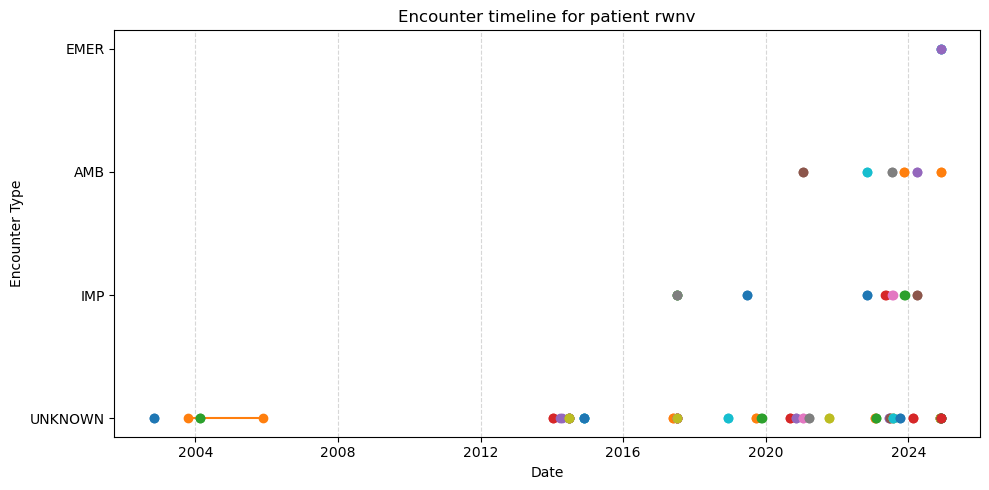

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# 🔹 If your 'encounter' is Dask, convert a small subset to pandas
try:
    sample_ids = encounter["patient_id"].dropna().drop_duplicates().head(10000).compute()
except Exception:
    sample_ids = encounter["patient_id"].dropna().drop_duplicates().head(10000)

# choose one random patient ID
pid = random.choice(sample_ids.tolist())
print(f"🎯 Randomly selected patient_id: {pid}")

# 🔹 Subset this patient’s encounters
try:
    sub = encounter[encounter["patient_id"] == pid].compute()
except Exception:
    sub = encounter[encounter["patient_id"] == pid]

# convert dates
sub["start_date"] = pd.to_datetime(sub["start_date"], errors="coerce")
sub["end_date"] = pd.to_datetime(sub["end_date"], errors="coerce")
sub = sub.sort_values("start_date")

# drop rows without start_date
sub = sub.dropna(subset=["start_date"])

# 🔹 Plot: encounter type over time (as horizontal bars)
plt.figure(figsize=(10, 5))
for i, row in enumerate(sub.itertuples()):
    y = row.type
    start = row.start_date
    end = row.end_date if pd.notna(row.end_date) else row.start_date
    plt.plot([start, end], [y, y], marker="o")

plt.title(f"Encounter timeline for patient {pid}")
plt.xlabel("Date")
plt.ylabel("Encounter Type")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
# Filtering Out patients that ibkt have one encounter 
encounter = encounter.groupby('patient_id').filter(lambda x: len(x) > 1)


In [15]:
import pandas as pd

# --- make sure date columns are datetime ---
encounter["start_date"] = pd.to_datetime(encounter["start_date"], errors="coerce")
encounter["end_date"] = pd.to_datetime(encounter["end_date"], errors="coerce").fillna(encounter["start_date"])

# --- split VR encounters and all other types ---
vr = encounter[encounter["type"].str.contains("VR", case=False, na=False)].copy()
non_vr = encounter[~encounter["type"].str.contains("VR", case=False, na=False)].copy()

# --- find overlaps within the same patient ---
records = []
for pid, vr_grp in vr.groupby("patient_id"):
    if pid not in non_vr["patient_id"].values:
        continue
    non_grp = non_vr[non_vr["patient_id"] == pid].sort_values("start_date")

    for _, vr_row in vr_grp.iterrows():
        overlap_mask = (
            (non_grp["start_date"] <= vr_row["end_date"]) &
            (non_grp["end_date"]   >= vr_row["start_date"])
        )
        overlapping = non_grp[overlap_mask]

        for _, nr in overlapping.iterrows():
            records.append({
                "patient_id": pid,
                # VR encounter
                "vr_encounter_id": vr_row["encounter_id"],
                "vr_start": vr_row["start_date"],
                "vr_end": vr_row["end_date"],
                "vr_type": vr_row["type"],
                # overlapping encounter
                "other_encounter_id": nr["encounter_id"],
                "other_type": nr["type"],
                "other_start": nr["start_date"],
                "other_end": nr["end_date"]
            })

# --- build final result table ---
overlap_with_vr = pd.DataFrame(records)
print(f"✅ Found {len(overlap_with_vr)} overlapping encounters with VR across {overlap_with_vr['patient_id'].nunique()} patients")

overlap_with_vr.head(10)

# Check for overlapped visits


✅ Found 25695 overlapping encounters with VR across 778 patients


,patient_id,vr_encounter_id,vr_start,vr_end,vr_type,other_encounter_id,other_type,other_start,other_end
0,4At6B,7QU2CG,2024-05-15,2024-05-15,VR,7gJ3CG,AMB,2024-05-15,2024-05-15
1,4At6B,7gU2CG,2024-05-29,2024-05-29,VR,7wJ3CG,AMB,2024-05-29,2024-05-29
2,4At6B,7wU2CG,2024-06-14,2024-06-14,VR,7AK3CG,AMB,2024-06-14,2024-06-14
3,4At6B,7AV2CG,2024-08-17,2024-08-17,VR,7gK3CG,AMB,2024-08-17,2024-08-17
4,4At6B,7QV2CG,2024-10-22,2024-10-22,VR,7wK3CG,AMB,2024-10-22,2024-10-22
5,4Qd,7QbJwG,2015-06-01,2015-06-01,VR,7AMKwG,UNKNOWN,2015-06-01,2015-06-01
6,4Qd,7QbJwG,2015-06-01,2015-06-01,VR,7AMQwG,AMB,2015-06-01,2015-06-01
7,4Qd,7gbJwG,2018-06-25,2018-06-25,VR,7QmSwG,UNKNOWN,2018-06-25,2018-06-25
8,4QjR,7QSMpH,2017-09-27,2017-09-27,VR,7wYMpH,UNKNOWN,2017-09-27,2017-09-27
9,4gFE,7wbp8G,2015-09-09,2015-09-09,VR,7Akq8G,AMB,2015-09-09,2015-09-09


In [68]:
import pandas as pd

# ensure both tables exist
diag = diagnosis        # your diagnosis table
enc = encounter         # your encounter table

# 1️⃣ Identify stroke patients
mask = diag["diagnosis_code"].astype(str).str.startswith(("I63", "I64"), na=False)
stroke_patients = diag.loc[mask, "patient_id"].dropna().unique()
print(f"🧠 Found {len(stroke_patients)} stroke patients")

# 2️⃣ Pick those patients in the encounter table
enc_stroke = enc[enc["patient_id"].isin(stroke_patients)].copy()
print(f"✅ Selected {enc_stroke['patient_id'].nunique()} stroke patients in encounter table")

enc_stroke.head()


# How mant stroke patients are there in the table


🧠 Found 5548 stroke patients
✅ Selected 5419 stroke patients in encounter table


,encounter_id,patient_id,start_date,end_date,type,start_date_derived_by_TriNetX,end_date_derived_by_TriNetX,derived_by_TriNetX,source_id,source_name
0,XAVG,UgzB,2022-09-19,2022-09-19,AMB,F,F,F,EHR,encounter
1,XQVG,UgzB,2022-12-20,2022-12-20,AMB,F,F,F,EHR,encounter
2,XgVG,UgzB,2023-01-11,2023-01-11,AMB,F,F,F,EHR,encounter
3,XwVG,UgzB,2023-02-16,2023-02-16,AMB,F,F,F,EHR,encounter
4,XAWG,UgzB,2023-04-20,2023-04-20,AMB,F,F,F,EHR,encounter


In [19]:
import pandas as pd

# Ensure dates are datetime
enc_stroke["start_date"] = pd.to_datetime(enc_stroke["start_date"], errors="coerce")
enc_stroke["end_date"]   = pd.to_datetime(enc_stroke["end_date"], errors="coerce").fillna(enc_stroke["start_date"])

# Split VR vs non-VR rows
vr     = enc_stroke[enc_stroke["type"].str.contains("VR", case=False, na=False)].copy()
non_vr = enc_stroke[~enc_stroke["type"].str.contains("VR", case=False, na=False)].copy()

# Find overlaps within the same patient
records = []
for pid, vr_grp in vr.groupby("patient_id"):
    ng = non_vr[non_vr["patient_id"] == pid]
    if ng.empty:
        continue
    for _, v in vr_grp.iterrows():
        mask = (ng["start_date"] <= v["end_date"]) & (ng["end_date"] >= v["start_date"])
        ovl = ng[mask]
        if ovl.empty:
            continue
        for _, r in ovl.iterrows():
            records.append({
                "patient_id": pid,
                # VR encounter
                "vr_encounter_id": v["encounter_id"],
                "vr_type": v["type"],
                "vr_start": v["start_date"],
                "vr_end": v["end_date"],
                # overlapping encounter
                "other_encounter_id": r["encounter_id"],
                "other_type": r["type"],
                "other_start": r["start_date"],
                "other_end": r["end_date"]
            })

overlap_vr_vs_other = pd.DataFrame(records)
print(f"✅ {len(overlap_vr_vs_other)} overlapping pairs across {overlap_vr_vs_other['patient_id'].nunique()} patients")
overlap_vr_vs_other.head(10)


# Overlapping VR with another type


✅ 16491 overlapping pairs across 479 patients


,patient_id,vr_encounter_id,vr_type,vr_start,vr_end,other_encounter_id,other_type,other_start,other_end
0,4Qd,7QbJwG,VR,2015-06-01,2015-06-01,7AMKwG,UNKNOWN,2015-06-01,2015-06-01
1,4Qd,7QbJwG,VR,2015-06-01,2015-06-01,7AMQwG,AMB,2015-06-01,2015-06-01
2,4Qd,7gbJwG,VR,2018-06-25,2018-06-25,7QmSwG,UNKNOWN,2018-06-25,2018-06-25
3,4QjR,7QSMpH,VR,2017-09-27,2017-09-27,7wYMpH,UNKNOWN,2017-09-27,2017-09-27
4,4gFE,7wbp8G,VR,2015-09-09,2015-09-09,7Akq8G,AMB,2015-09-09,2015-09-09
5,4gGz,7w_w2,VR,2020-08-20,2020-08-20,7A_w2,UNKNOWN,2020-08-20,2020-08-20
6,4gGz,7w_w2,VR,2020-08-20,2020-08-20,7Q_w2,UNKNOWN,2020-08-20,2020-08-20
7,4gGz,7w_w2,VR,2020-08-20,2020-08-20,7gIx2,EMER,2020-08-19,2020-09-10
8,4gGz,7w_w2,VR,2020-08-20,2020-08-20,7wIx2,EMER,2020-08-20,2020-08-20
9,4gGz,7w_w2,VR,2020-08-20,2020-08-20,7QOx2,UNKNOWN,2020-08-20,2020-08-20


🎯 Selected patient_id with VR overlap: gRpmF


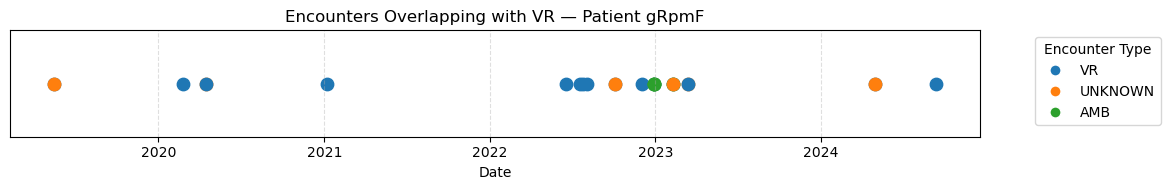

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# randomly pick a patient who has VR overlaps for only stroke patients
pid = random.choice(overlap_vr_vs_other["patient_id"].unique().tolist())
print(f"🎯 Selected patient_id with VR overlap: {pid}")

# subset encounters for that patient
sub = enc_stroke[enc_stroke["patient_id"] == pid].copy()
sub["start_date"] = pd.to_datetime(sub["start_date"], errors="coerce")
sub["end_date"] = pd.to_datetime(sub["end_date"], errors="coerce").fillna(sub["start_date"])
sub = sub.dropna(subset=["start_date"]).sort_values("start_date")

# separate VR and non-VR encounters
vr_rows = sub[sub["type"].str.contains("VR", case=False, na=False)]
other_rows = sub[~sub["type"].str.contains("VR", case=False, na=False)]

# collect overlapping encounters
overlap_list = []

for _, vr in vr_rows.iterrows():
    mask = (other_rows["start_date"] <= vr["end_date"]) & (other_rows["end_date"] >= vr["start_date"])
    overlaps = other_rows[mask]
    # keep both the VR encounter and overlapping others
    overlap_list.append(vr.to_frame().T)
    if not overlaps.empty:
        overlap_list.append(overlaps)

# combine all overlapping encounters
if overlap_list:
    overlap_df = pd.concat(overlap_list).drop_duplicates().sort_values("start_date")

    # assign colors for each encounter type
    types = overlap_df["type"].unique()
    colors = plt.cm.tab10.colors
    color_map = {t: colors[i % len(colors)] for i, t in enumerate(types)}

    # plot: one line of dots
    plt.figure(figsize=(10, 2))
    for _, row in overlap_df.iterrows():
        plt.scatter(row["start_date"], 0, color=color_map[row["type"]], s=80)

    # labels and legend
    plt.title(f"Encounters Overlapping with VR — Patient {pid}")
    plt.xlabel("Date")
    plt.yticks([])
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()

    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=c, markersize=8)
               for t, c in color_map.items()]
    plt.legend(handles, color_map.keys(), title="Encounter Type",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show()
else:
    print(f"ℹ️ No overlaps with VR found for patient {pid}.")

    #Visualize for individual patients


<Axes: xlabel='other_type'>

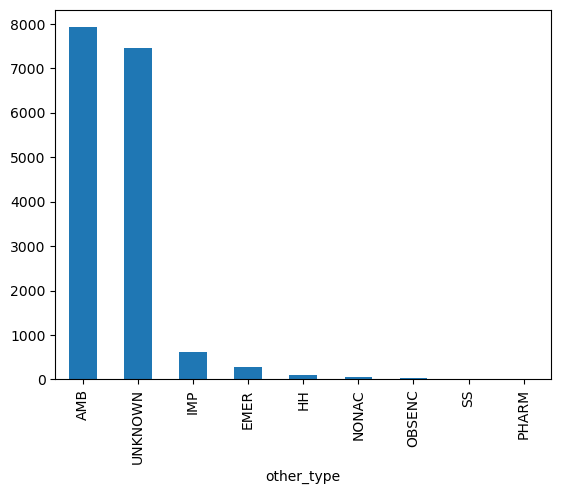

In [49]:
overlap_vr_vs_other["other_type"].value_counts().plot(kind="bar")


In [73]:
import plotly.express as px
import pandas as pd
import plotly.io as pio

# 1️⃣ Prepare data
df_pairs = overlap_vr_vs_other.copy()

# convert to datetime
for c in ["vr_start", "vr_end", "other_start", "other_end"]:
    df_pairs[c] = pd.to_datetime(df_pairs[c], errors="coerce")

# keep both VR and overlapping "other" encounters
vr_df = df_pairs[["patient_id","vr_encounter_id","vr_type","vr_start"]].rename(
    columns={"vr_encounter_id":"encounter_id","vr_type":"enc_type","vr_start":"date"}
)
other_df = df_pairs[["patient_id","other_encounter_id","other_type","other_start"]].rename(
    columns={"other_encounter_id":"encounter_id","other_type":"enc_type","other_start":"date"}
)
plot_df = pd.concat([vr_df, other_df], ignore_index=True)
plot_df = plot_df.dropna(subset=["date"])

# 🕒 2️⃣ Filter for encounters after 2015
plot_df = plot_df[plot_df["date"].dt.year > 2015]

# optional: sample patients to avoid overcrowding
sample_patients = plot_df["patient_id"].drop_duplicates().sample(
    min(30, plot_df["patient_id"].nunique()), random_state=0
)
plot_df = plot_df[plot_df["patient_id"].isin(sample_patients)]

# 3️⃣ Scatter plot
fig = px.scatter(
    plot_df,
    x="date",
    y="patient_id",
    color="enc_type",
    symbol="enc_type",
    hover_data=["encounter_id"],
    title="VR and Overlapping Encounters After 2015 (as Points)",
)

fig.update_yaxes(autorange="reversed")
fig.update_traces(marker=dict(size=8))
pio.renderers.default = "browser"  # or "notebook_connected", "vscode", etc.
fig.show()


# Visualization for more than one patient randomly sampled


In [67]:
import pandas as pd

# --- 1) Ensure needed columns and datatypes ---
# (Assumes columns: patient_id, encounter_id, type, start_date)
enc = encounter.copy()
enc["start_date"] = pd.to_datetime(enc["start_date"], errors="coerce")
enc = enc.dropna(subset=["patient_id", "start_date"]).sort_values(["patient_id", "start_date"])

# --- 2) Build previous-encounter columns within each patient ---
enc["prev_date"] = enc.groupby("patient_id")["start_date"].shift(1)
enc["prev_id"]   = enc.groupby("patient_id")["encounter_id"].shift(1)
enc["prev_type"] = enc.groupby("patient_id")["type"].shift(1)

# --- 3) Compute gap (days) and keep pairs within 14 days (excluding same-day = 0) ---
enc["days_between"] = (enc["start_date"] - enc["prev_date"]).dt.days
within14 = enc[(enc["days_between"] >= 0) & (enc["days_between"] <= 14)].copy()

# --- 4) Produce a tidy pairs table ---
pairs14 = within14.rename(columns={
    "patient_id": "patient_id",
    "prev_id": "encounter_id_1",
    "prev_type": "type_1",
    "prev_date": "date_1",
    "encounter_id": "encounter_id_2",
    "type": "type_2",
    "start_date": "date_2"
})[[
    "patient_id", "encounter_id_1", "type_1", "date_1",
    "encounter_id_2", "type_2", "date_2", "days_between"
]]

print(f"✅ Found {len(pairs14)} encounter pairs within 14 days across {pairs14['patient_id'].nunique()} patients.")
display(pairs14.head(10))  # comment out if not in notebook

# --- 5) How many of these pairs involve VR? (either side is VR) ---
vr_pairs = pairs14[
    pairs14["type_1"].astype(str).str.contains("VR", case=False, na=False) |
    pairs14["type_2"].astype(str).str.contains("VR", case=False, na=False)
]
print(f"🩺 {len(vr_pairs)} of these pairs involve at least one VR encounter "
      f"({vr_pairs['patient_id'].nunique()} patients).")

# --- 6) Optional: summarize by pair type (e.g., VR→Inpatient, Outpatient→VR, etc.) ---
pair_type_counts = (vr_pairs
                    .assign(pair_type=vr_pairs["type_1"].astype(str) + " → " + vr_pairs["type_2"].astype(str))
                    .groupby("pair_type").size().sort_values(ascending=False))
print("\nTop VR-involved pair types:\n", pair_type_counts.head(20))

 # Encounter pair with in 14 day, how many pairs

✅ Found 1403403 encounter pairs within 14 days across 9297 patients.


,patient_id,encounter_id_1,type_1,date_1,encounter_id_2,type_2,date_2,days_between
1523600,#A#h,Chb68,AMB,2013-12-16,Cxb68,AMB,2013-12-16,0.0
1523602,#A#h,CBc68,AMB,2014-01-07,CRc68,AMB,2014-01-15,8.0
1523603,#A#h,CRc68,AMB,2014-01-15,Chc68,AMB,2014-01-24,9.0
1523604,#A#h,Chc68,AMB,2014-01-24,Cxc68,AMB,2014-01-28,4.0
1523605,#A#h,Cxc68,AMB,2014-01-28,CBd68,AMB,2014-01-29,1.0
1523606,#A#h,CBd68,AMB,2014-01-29,CRd68,AMB,2014-01-29,0.0
1523607,#A#h,CRd68,AMB,2014-01-29,Chd68,AMB,2014-02-07,9.0
1523608,#A#h,Chd68,AMB,2014-02-07,Cxd68,AMB,2014-02-13,6.0
1523609,#A#h,Cxd68,AMB,2014-02-13,CBe68,AMB,2014-02-17,4.0
1523610,#A#h,CBe68,AMB,2014-02-17,CRe68,AMB,2014-02-17,0.0


🩺 46725 of these pairs involve at least one VR encounter (1012 patients).

Top VR-involved pair types:
 pair_type
VR → VR         11023
AMB → VR        10926
VR → UNKNOWN     9021
VR → AMB         8042
UNKNOWN → VR     6651
VR → IMP          337
VR → EMER         313
IMP → VR          131
VR → NONAC         62
EMER → VR          58
HH → VR            51
VR → HH            39
NONAC → VR         36
VR → OBSENC        10
OBSENC → VR         8
VR → SS             8
PHARM → VR          5
SS → VR             4
dtype: int64


In [56]:
import pandas as pd

# --- 1️⃣ Identify stroke encounters from diagnosis table ---
# Replace `diagnosis` with your diagnosis DataFrame name
stroke_diag = diagnosis[diagnosis["diagnosis_code"].astype(str).str.startswith(("I63", "I64"), na=False)].copy()

# extract encounter IDs for stroke
stroke_encounter_ids = stroke_diag["encounter_id"].dropna().unique()
print(f"🧠 Found {len(stroke_encounter_ids)} stroke-related encounters")

# --- 2️⃣ Filter encounter table to stroke encounters only ---
enc_stroke = encounter[encounter["encounter_id"].isin(stroke_encounter_ids)].copy()

# convert dates to datetime
enc_stroke["start_date"] = pd.to_datetime(enc_stroke["start_date"], errors="coerce")
enc_stroke = enc_stroke.dropna(subset=["patient_id", "start_date"])
enc_stroke = enc_stroke.sort_values(["patient_id", "start_date"])

# --- 3️⃣ Find encounters within 14 days for same patient ---
records = []
for pid, grp in enc_stroke.groupby("patient_id"):
    grp = grp.reset_index(drop=True)
    for i in range(1, len(grp)):
        diff = (grp.loc[i, "start_date"] - grp.loc[i-1, "start_date"]).days
        if 0 < diff <= 14:  # within 14 days
            records.append({
                "patient_id": pid,
                "encounter_id_1": grp.loc[i-1, "encounter_id"],
                "type_1": grp.loc[i-1, "type"],
                "date_1": grp.loc[i-1, "start_date"],
                "encounter_id_2": grp.loc[i, "encounter_id"],
                "type_2": grp.loc[i, "type"],
                "date_2": grp.loc[i, "start_date"],
                "days_between": diff
            })

within14 = pd.DataFrame(records)
print(f"✅ Found {len(within14)} encounter pairs within 14 days (same patient, stroke diagnosis)")
within14.head(10)

# --- 4️⃣ Count how many of them involve VR encounters ---
# “VR” can appear in either type_1 or type_2
vr_pairs = within14[within14["type_1"].str.contains("VR", case=False, na=False) |
                    within14["type_2"].str.contains("VR", case=False, na=False)]

print(f"🩺 {len(vr_pairs)} of these 14-day pairs involve at least one VR encounter "
      f"({vr_pairs['patient_id'].nunique()} patients)")

vr_pairs.head(10)

#Patients with stroke diagnosis, had repeated encounter in the last 14 days, at least one of the repeated encounter is VR
# Not correct have to come back for it


🧠 Found 32101 stroke-related encounters
✅ Found 8493 encounter pairs within 14 days (same patient, stroke diagnosis)
🩺 67 of these 14-day pairs involve at least one VR encounter (35 patients)


,patient_id,encounter_id_1,type_1,date_1,encounter_id_2,type_2,date_2,days_between
1320,NQ5LB,Qg0BpG,VR,2020-06-10,QQIBpG,AMB,2020-06-11,1
1332,NQrUB,QQD7qH,IMP,2022-10-15,Qwf7qH,VR,2022-10-21,6
1423,Nw3UC,QwAEdO,VR,2015-09-01,QwpCdO,AMB,2015-09-08,7
1447,NwJ0,QwkZuD,AMB,2022-09-14,QguZuD,VR,2022-09-21,7
1448,NwJ0,QguZuD,VR,2022-09-21,QwqZuD,AMB,2022-09-24,3
1534,OBn7,RxFhgD,IMP,2020-03-21,RBchgD,VR,2020-03-25,4
1645,QQMn,TwHj6B,AMB,2012-10-09,TgUj6B,VR,2012-10-19,10
1655,QQMn,TAVj6B,VR,2013-08-09,TAJj6B,AMB,2013-08-13,4
1662,QQMn,TQVj6B,VR,2014-09-10,TgVj6B,VR,2014-09-13,3
1663,QQMn,TgVj6B,VR,2014-09-13,TgKj6B,AMB,2014-09-23,10


In [60]:
import pandas as pd

# 0) Build a diagnosis table with a date per dx (use encounter start_date)
diag = diagnosis.merge(
    encounter[["encounter_id", "patient_id", "start_date"]],
    on=["encounter_id", "patient_id"],
    how="left",
)
diag = diag.rename(columns={"start_date": "dx_date"})
diag["dx_date"] = pd.to_datetime(diag["dx_date"], errors="coerce")

# 1) Patients' first stroke date (I63/I64)
stroke = diag[diag["diagnosis_code"].astype(str).str.startswith(("I63", "I64"), na=False)].copy()
first_stroke = (stroke
                .dropna(subset=["dx_date"])
                .groupby("patient_id", as_index=False)["dx_date"].min()
                .rename(columns={"dx_date": "first_stroke_date"}))

# 2) Mental health diagnoses (F01–F99) after first stroke
mh = diag[diag["diagnosis_code"].astype(str).str.match(r"^F\d{2}", na=False)].copy()
mh = mh.dropna(subset=["dx_date"])

mh_after_stroke = (mh
                   .merge(first_stroke, on="patient_id", how="inner")
                   .query("dx_date > first_stroke_date"))

# Results
patients_mh_after_stroke = mh_after_stroke["patient_id"].drop_duplicates()
print(f"✅ Patients with MH dx after stroke: {patients_mh_after_stroke.nunique()}")

# Optional: tidy table of first stroke + first MH-after-stroke per patient
first_mh_after = (mh_after_stroke
                  .sort_values(["patient_id", "dx_date"])
                  .groupby("patient_id", as_index=False)
                  .first()[["patient_id", "diagnosis_code", "dx_date", "first_stroke_date"]]
                  .rename(columns={"diagnosis_code": "first_MH_code_after_stroke",
                                   "dx_date": "first_MH_date_after_stroke"}))

first_mh_after.head()

# First stroke then develope mental health problem

✅ Patients with MH dx after stroke: 2279


,patient_id,first_MH_code_after_stroke,first_MH_date_after_stroke,first_stroke_date
0,#A#h,F41.8,2023-01-20,2014-03-06
1,#A2N,F17.211,2023-01-25,2022-12-12
2,#A7u,F03.90,2021-03-24,2021-01-01
3,#AAa,F17.290,2023-04-05,2017-12-01
4,#AD0,F50.89,2024-08-15,2024-07-26


In [70]:
import pandas as pd

# --- Ensure dates ---
encounter["start_date"] = pd.to_datetime(encounter["start_date"], errors="coerce")
encounter["end_date"]   = pd.to_datetime(encounter.get("end_date"), errors="coerce")
encounter["end_date"]   = encounter["end_date"].fillna(encounter["start_date"])

# --- Work within the MH-after-stroke cohort ---
enc = encounter[encounter["patient_id"].isin(patients_mh_after_stroke)].copy()
enc = enc.dropna(subset=["patient_id","start_date"]).sort_values(["patient_id","start_date"])

# --- Split VR and ALL encounters ---
vr = enc[enc["type"].astype(str).str.contains("VR", case=False, na=False)].copy()

records = []

# --- For each patient, find ANY encounter overlapping a VR encounter ---
for pid, vr_grp in vr.groupby("patient_id"):
    all_enc = enc[enc["patient_id"] == pid]
    for _, v in vr_grp.iterrows():
        overlap_mask = (all_enc["start_date"] <= v["end_date"]) & (all_enc["end_date"] >= v["start_date"])
        ovl = all_enc[overlap_mask]
        if ovl.empty:
            continue
        for _, r in ovl.iterrows():
            records.append({
                "patient_id": pid,
                "vr_encounter_id": v["encounter_id"],
                "vr_type": v["type"],
                "vr_start": v["start_date"],
                "vr_end": v["end_date"],
                "overlap_encounter_id": r["encounter_id"],
                "overlap_type": r["type"],
                "overlap_start": r["start_date"],
                "overlap_end": r["end_date"]
            })

# --- Build DataFrame ---
overlap_any_with_vr = pd.DataFrame(records)

# --- Summary ---
n_mh_after = len(patients_mh_after_stroke)
n_with_vr  = vr["patient_id"].nunique()
n_overlap  = overlap_any_with_vr["patient_id"].nunique()

print(f"🧠 Patients (MH-after-stroke): {n_mh_after}")
print(f"📹 Patients with ≥1 VR encounter: {n_with_vr}")
print(f"🔁 Patients with ≥1 encounter overlapping a VR encounter: {n_overlap}")

# --- Peek at results ---
overlap_any_with_vr.head(10)


🧠 Patients (MH-after-stroke): 2279
📹 Patients with ≥1 VR encounter: 389
🔁 Patients with ≥1 encounter overlapping a VR encounter: 389


,patient_id,vr_encounter_id,vr_type,vr_start,vr_end,overlap_encounter_id,overlap_type,overlap_start,overlap_end
0,4A0h,7wuRiI,VR,2014-02-26,2014-02-26,7wuRiI,VR,2014-02-26,2014-02-26
1,4Q38,7g9XeB,VR,2020-11-15,2020-11-15,7g9XeB,VR,2020-11-15,2020-11-15
2,4Qd,7QaJwG,VR,2014-02-24,2014-02-24,7QaJwG,VR,2014-02-24,2014-02-24
3,4Qd,7gaJwG,VR,2014-04-05,2014-04-05,7gaJwG,VR,2014-04-05,2014-04-05
4,4Qd,7waJwG,VR,2014-05-23,2014-05-23,7waJwG,VR,2014-05-23,2014-05-23
5,4Qd,7AbJwG,VR,2015-04-30,2015-04-30,7AbJwG,VR,2015-04-30,2015-04-30
6,4Qd,7QbJwG,VR,2015-06-01,2015-06-01,7QbJwG,VR,2015-06-01,2015-06-01
7,4Qd,7QbJwG,VR,2015-06-01,2015-06-01,7AMKwG,UNKNOWN,2015-06-01,2015-06-01
8,4Qd,7QbJwG,VR,2015-06-01,2015-06-01,7AMQwG,AMB,2015-06-01,2015-06-01
9,4Qd,7gbJwG,VR,2018-06-25,2018-06-25,7gbJwG,VR,2018-06-25,2018-06-25


In [65]:

enc = encounter[encounter["patient_id"].isin(patients_mh_after_stroke)].copy()

# dates & sort
enc["start_date"] = pd.to_datetime(enc["start_date"], errors="coerce")
enc = enc.dropna(subset=["patient_id","start_date"]).sort_values(["patient_id","start_date"])

# build previous encounter within patient
enc["prev_date"] = enc.groupby("patient_id")["start_date"].shift(1)
enc["prev_id"]   = enc.groupby("patient_id")["encounter_id"].shift(1)
enc["prev_type"] = enc.groupby("patient_id")["type"].shift(1)

# gap in days; keep pairs within 14 days (exclude same-day = 0)
enc["days_between"] = (enc["start_date"] - enc["prev_date"]).dt.days
within14_mh_after = enc[(enc["days_between"] > 0) & (enc["days_between"] <= 14)].copy()

# tidy pairs table (same shape as your example)
pairs14_mh_after = within14_mh_after.rename(columns={
    "prev_id": "encounter_id_1",
    "prev_type": "type_1",
    "prev_date": "date_1",
    "encounter_id": "encounter_id_2",
    "type": "type_2",
    "start_date": "date_2"
})[[
    "patient_id", "encounter_id_1", "type_1", "date_1",
    "encounter_id_2", "type_2", "date_2", "days_between"
]]

print(f"✅ Found {len(pairs14_mh_after)} encounter pairs within 14 days "
      f"across {pairs14_mh_after['patient_id'].nunique()} patients (MH-after-stroke cohort).")

# how many involve VR (either side)
vr_pairs_mh_after = pairs14_mh_after[
    pairs14_mh_after["type_1"].astype(str).str.contains("VR", case=False, na=False) |
    pairs14_mh_after["type_2"].astype(str).str.contains("VR", case=False, na=False)
]

print(f"🩺 VR-involved pairs: {len(vr_pairs_mh_after)} "
      f"({vr_pairs_mh_after['patient_id'].nunique()} patients).")

# peek
pairs14_mh_after.head(10)
# vr_pairs_mh_after.head(10)

✅ Found 310507 encounter pairs within 14 days across 2253 patients (MH-after-stroke cohort).
🩺 VR-involved pairs: 15305 (364 patients).


,patient_id,encounter_id_1,type_1,date_1,encounter_id_2,type_2,date_2,days_between
1523602,#A#h,CBc68,AMB,2014-01-07,CRc68,AMB,2014-01-15,8.0
1523603,#A#h,CRc68,AMB,2014-01-15,Chc68,AMB,2014-01-24,9.0
1523604,#A#h,Chc68,AMB,2014-01-24,Cxc68,AMB,2014-01-28,4.0
1523605,#A#h,Cxc68,AMB,2014-01-28,CBd68,AMB,2014-01-29,1.0
1523607,#A#h,CRd68,AMB,2014-01-29,Chd68,AMB,2014-02-07,9.0
1523608,#A#h,Chd68,AMB,2014-02-07,Cxd68,AMB,2014-02-13,6.0
1523609,#A#h,Cxd68,AMB,2014-02-13,CBe68,AMB,2014-02-17,4.0
1523598,#A#h,Che68,AMB,2014-03-06,CRb68,IMP,2014-03-10,4.0
1523613,#A#h,Cxe68,AMB,2014-04-02,CBf68,AMB,2014-04-03,1.0
1523617,#A#h,Cxf68,AMB,2014-04-03,CBg68,AMB,2014-04-04,1.0


In [72]:
import pandas as pd

# --- 0) Stroke patients via diagnosis table (I60–I69) ---
stroke_mask = diagnosis["diagnosis_code"].astype(str).str.match(r"^I6[0-9]", na=False)
stroke_patients = diagnosis.loc[stroke_mask, "patient_id"].dropna().unique()

# --- 1) Filter encounters to stroke patients & prep dates ---
enc = encounter[encounter["patient_id"].isin(stroke_patients)].copy()
enc["start_date"] = pd.to_datetime(enc["start_date"], errors="coerce")
enc["end_date"]   = pd.to_datetime(enc.get("end_date"), errors="coerce").fillna(enc["start_date"])
enc = enc.dropna(subset=["patient_id","encounter_id","start_date"]).sort_values(["patient_id","start_date"])

# --- 2) Split VR vs all encounters (within stroke cohort) ---
vr = enc[enc["type"].astype(str).str.contains("VR", case=False, na=False)].copy()

rows = []
for pid, vr_grp in vr.groupby("patient_id"):
    all_p = enc[enc["patient_id"] == pid]
    for _, v in vr_grp.iterrows():
        # overlap rule: A starts before VR ends AND A ends after VR starts
        mask = (all_p["start_date"] <= v["end_date"]) & (all_p["end_date"] >= v["start_date"])
        ovl = all_p[mask]
        # drop the VR encounter itself
        ovl = ovl[ovl["encounter_id"] != v["encounter_id"]]
        if ovl.empty:
            continue
        for _, r in ovl.iterrows():
            rows.append({
                "patient_id": pid,
                # VR side
                "vr_encounter_id": v["encounter_id"],
                "vr_start": v["start_date"],
                "vr_end": v["end_date"],
                "vr_type": v["type"],
                # overlapping encounter (any type)
                "overlap_encounter_id": r["encounter_id"],
                "overlap_start": r["start_date"],
                "overlap_end": r["end_date"],
                "overlap_type": r["type"],
                # flag VR–VR vs VR–nonVR
                "overlap_is_vr": bool(pd.notna(r["type"]) and ("VR" in str(r["type"]).upper()))
            })

overlap_any_with_vr_stroke = pd.DataFrame(rows)

# --- 3) Summaries ---
n_stroke_patients   = len(stroke_patients)
n_with_vr           = vr["patient_id"].nunique()
n_with_any_overlap  = overlap_any_with_vr_stroke["patient_id"].nunique()
n_vrvr_pairs        = overlap_any_with_vr_stroke.query("overlap_is_vr").shape[0]
n_vr_nonvr_pairs    = overlap_any_with_vr_stroke.shape[0] - n_vrvr_pairs

print(f"🧠 Stroke patients (I60–I69): {n_stroke_patients}")
print(f"📹 Stroke patients with ≥1 VR encounter: {n_with_vr}")
print(f"🔁 Stroke patients with ≥1 encounter overlapping a VR encounter: {n_with_any_overlap}")
print(f"➡️ Overlap pairs total: {overlap_any_with_vr_stroke.shape[0]} "
      f"(VR–VR: {n_vrvr_pairs}, VR–nonVR: {n_vr_nonvr_pairs})")

# Peek
overlap_any_with_vr_stroke.head(10)


🧠 Stroke patients (I60–I69): 7072
📹 Stroke patients with ≥1 VR encounter: 823
🔁 Stroke patients with ≥1 encounter overlapping a VR encounter: 632
➡️ Overlap pairs total: 32481 (VR–VR: 9442, VR–nonVR: 23039)


,patient_id,vr_encounter_id,vr_start,vr_end,vr_type,overlap_encounter_id,overlap_start,overlap_end,overlap_type,overlap_is_vr
0,4AfF,7wbLBH,2021-02-19,2021-02-19,VR,7AcLBH,2021-02-19,2021-02-19,VR,True
1,4AfF,7AcLBH,2021-02-19,2021-02-19,VR,7wbLBH,2021-02-19,2021-02-19,VR,True
2,4At6B,7QU2CG,2024-05-15,2024-05-15,VR,7gJ3CG,2024-05-15,2024-05-15,AMB,False
3,4At6B,7gU2CG,2024-05-29,2024-05-29,VR,7wJ3CG,2024-05-29,2024-05-29,AMB,False
4,4At6B,7wU2CG,2024-06-14,2024-06-14,VR,7AK3CG,2024-06-14,2024-06-14,AMB,False
5,4At6B,7AV2CG,2024-08-17,2024-08-17,VR,7gK3CG,2024-08-17,2024-08-17,AMB,False
6,4At6B,7QV2CG,2024-10-22,2024-10-22,VR,7wK3CG,2024-10-22,2024-10-22,AMB,False
7,4Qd,7QbJwG,2015-06-01,2015-06-01,VR,7AMKwG,2015-06-01,2015-06-01,UNKNOWN,False
8,4Qd,7QbJwG,2015-06-01,2015-06-01,VR,7AMQwG,2015-06-01,2015-06-01,AMB,False
9,4Qd,7gbJwG,2018-06-25,2018-06-25,VR,7QmSwG,2018-06-25,2018-06-25,UNKNOWN,False
